### Data Input, Data Pre-Processing and Training Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 60, 60, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 58, 58, 64)        18496     
                                                                 
 activation_2 (Activation)   (None, 58, 58, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 56, 56, 64)        3

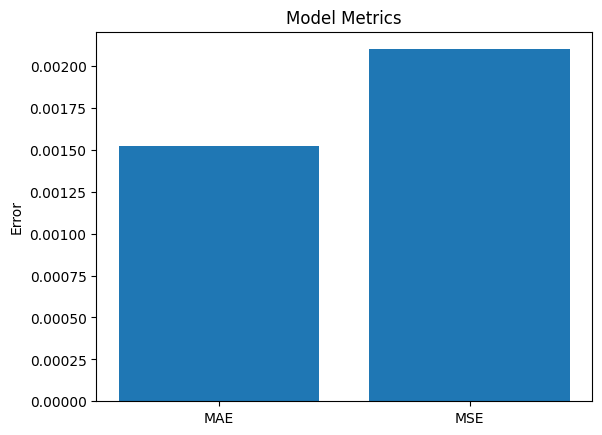

saving catalog...
catalog saved


In [ ]:
.no_angles = 360
url ='/content/drive/MyDrive/Major Project/all-mias/'

def save_dictionary(path, data):
    print('saving catalog...')
    import json
    with open(path,'w') as outfile:
        json.dump(str(data), fp=outfile)
    print('catalog saved')

def read_image():
    import cv2
    info = {}
    for i in range(322):
        if i < 9:
            image_name = 'mdb00' + str(i+1)
        elif i < 99:
            image_name = 'mdb0' + str(i+1)
        else:
            image_name = 'mdb' + str(i+1)
        image_address = url + image_name + '.pgm'
        img = cv2.imread(image_address, 0)
        img = cv2.resize(img, (64, 64))
        rows, cols = img.shape
        info[image_name] = {}
        for angle in range(no_angles):
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            img_rotated = cv2.warpAffine(img, M, (cols, rows))
            info[image_name][angle] = img_rotated
        
    return info

def read_label():
    filename = url + 'Info.txt'
    text_all = open(filename).read()
    lines = text_all.split('\n')
    info = {}
    for line in lines:
        words = line.split(' ')
        if len(words) >3:
            if words[3] == 'B':
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 1   # assign 1 for benign
            elif words[3] == 'M':
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2   # assign 2 for malignant
            elif words[3] == 'N':   # add normal case
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 0   # assign 0 for normal
    
    return info


def training():
    from sklearn.model_selection import train_test_split
    import numpy as np
    label_info = read_label()
    image_info = read_image()
    ids = label_info.keys()
    del label_info['Truth-Data:']
    X = []
    Y = []
    for id in ids:
        for angle in range(no_angles):
            X.append(image_info[id][angle])
            Y.append(label_info[id][angle])
    X = np.array(X)
    Y = np.array(Y)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
    a, b, c = x_train.shape
    x_train = np.reshape(x_train, (a, b, c, 1))
    a, b, c = x_test.shape
    x_test = np.reshape(x_test, (a, b, c, 1))
    cancer_prediction_cnn(x_train, y_train, x_test, y_test)

def cancer_prediction_cnn(x_train, y_train, x_test, y_test):
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
    from keras import optimizers
    from keras import losses
    from sklearn.metrics import f1_score, roc_curve, auc, mean_squared_error, mean_absolute_error
    from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, classification_report
    rows, cols,color = x_train[0].shape
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(rows, cols, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1, 1)))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))  # Output layer with 3 neurons for 3 classes
    model.add(Activation('softmax'))  # Use softmax activation for multi-class classification
    model.summary()
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=40, batch_size=128)
    loss_value , metrics = model.evaluate(x_test, y_test)
    print('Test_loss_value = ' +str(loss_value))
    print('test_accuracy = ' + str(metrics))
    y_pred = model.predict(x_test)
    print(y_pred)
    from keras.engine.data_adapter import abc
    import numpy as np
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten
    from keras import optimizers
    from keras import losses
    from sklearn.metrics import f1_score, roc_curve, auc, mean_squared_error, mean_absolute_error
    from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
    from matplotlib import pyplot as plt
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    print('F1 score: {:.4f}'.format(f1))
    
    # Calculate AUC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, 1], pos_label=2)
    roc_auc = auc(fpr, tpr)
    print('AUC score: {:.4f}'.format(roc_auc))
    
    # Calculate mean squared error
    mse = mean_squared_error(y_test, y_pred_classes)
    print('MSE: {:.4f}'.format(mse))
    
    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, y_pred_classes)
    print('MAE: {:.4f}'.format(mae))# Plot the metrics
    plt.bar(["MAE", "MSE"], [mae, mse])
    plt.ylabel("Error")
    plt.title("Model Metrics")
    plt.show()

    model.save('breast_cancer_model.h5')
    save_dictionary('history1.dat', history)
   
    # # # Calculate the metrics
    # accuracy = accuracy_score(y_pred, y_test)
    # precision = precision_score(y_test, y_pred, average='weighted')
    # print(classification_report(y_pred, y_test))
    # confusion_matrix(y_pred, y_test)

    # # Print the metrics
    # print("Accuracy:", accuracy)
    # print("Precision:", precision)
    # print("Confusion Matrix:\n", confusion_mat)

training()